In [1]:
#import os
#os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend' # https://github.com/plaidml/plaidml/blob/master/docs/index.md

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# keras version still end up import tf.keras version which is incompatible, import directly instead
from tensorflow.keras.callbacks import TensorBoard

In [2]:
encoding_dim = 1

In [3]:
input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu')(input_img) # apply to previous layer = input_img
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.run_eagerly = True # plaidml / keras not running eager mode by default

encoder = Model(input_img, encoded)

encoded_input = Input(shape=(encoding_dim,))

decoder_layer = autoencoder.layers[-1] # extract last layer

decoder = Model(encoded_input, decoder_layer(encoded_input))

In [4]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [5]:
# Load mnist dataset
(x_train, _),(x_test, _) = mnist.load_data()

print(len(x_train))
print(len(x_test))

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train = x_train.reshape(len(x_train), (np.prod(x_train.shape[1:])))
x_test = x_test.reshape(len(x_test), (np.prod(x_test.shape[1:])))

print(f'x_train shape = {x_train.shape}')
print(f'x_test shape = {x_test.shape}')

60000
10000
x_train shape = (60000, 784)
x_test shape = (10000, 784)


In [ ]:
%%time
import os
import time

CURRENT_TIME = int(time.time())
print(CURRENT_TIME)

try:
    os.makedirs(f'autoencoder_mnist/logs-{CURRENT_TIME}')
except Exception:
    pass

# Run this in a terminal
#tensorboard --logdir=autoencoder_mnist/logs

CALLBACKS=[
    TensorBoard(log_dir=f'autoencoder_mnist/logs-{CURRENT_TIME}')
]

# Fit data
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test), callbacks=CALLBACKS)

print(CURRENT_TIME)

1595258315
Epoch 1/50
235/235 [==============================] - 46s 198ms/step - loss: 0.4261 - val_loss: 0.2889
Epoch 2/50
235/235 [==============================] - 23s 97ms/step - loss: 0.2804 - val_loss: 0.2737
Epoch 3/50
235/235 [==============================] - 26s 112ms/step - loss: 0.2712 - val_loss: 0.2680
Epoch 4/50
235/235 [==============================] - 26s 111ms/step - loss: 0.2644 - val_loss: 0.2631
Epoch 6/50
235/235 [==============================] - 25s 109ms/step - loss: 0.2626 - val_loss: 0.2616
Epoch 7/50
235/235 [==============================] - 19s 82ms/step - loss: 0.2449 - val_loss: 0.2441
Epoch 45/50
235/235 [==============================] - 18s 77ms/step - loss: 0.2445 - val_loss: 0.2437
Epoch 46/50
235/235 [==============================] - 19s 81ms/step - loss: 0.2441 - val_loss: 0.2434
Epoch 47/50
235/235 [==============================] - 18s 76ms/step - loss: 0.2438 - val_loss: 0.2431
Epoch 48/50
235/235 [==============================] - 18s 76ms/

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

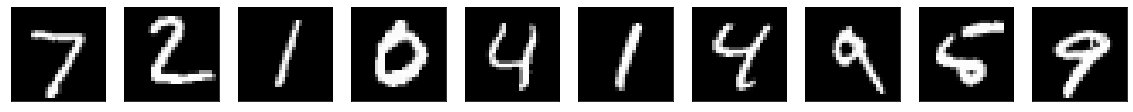

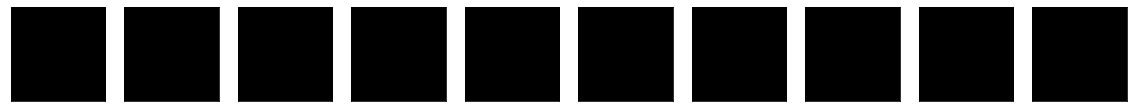

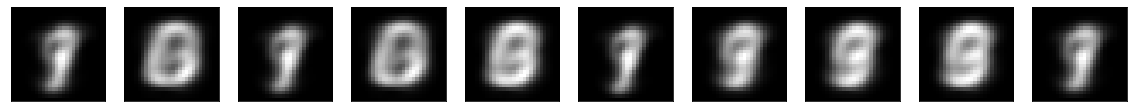

Wall time: 4.92 s


In [12]:
%%time
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    # What does encoded images looks like?
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(1*1,1)) # encoded 64 # (8,8) # (4, 4*4)
    #plt.imshow(decoded_imgs[i].reshape(4, 14*14).T) # input or decoded 784 # (28,28) # (4, 14*14)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [13]:
%%time
# https://dsp.stackexchange.com/questions/38065/peak-signal-to-noise-ratio-psnr-in-python-for-an-image
import math
import numpy as np

def mse(img1, img2):
    return np.mean( (img1 - img2) ** 2 )

def psnr(img1, img2):
    mserr = mse(img1, img2)
    PIXEL_MAX = 1.0
    try:
        return 20 * math.log10(PIXEL_MAX / math.sqrt(mserr))
    except ZeroDivisionError:
        return 'Same image'

n = 10
for i in range(n):
    original = x_test[i]
    contrast = decoded_imgs[i]
    a = mse(original, contrast)
    b = psnr(original, contrast) # can also use cv2.PSNR rather than defined function psnr
    if b != 'Same image':
        print(f'MSE = {a:.4f}, PSNR (dB) = {b:.2f}')
    else:
        print(f'MSE = {a:.4f}, PSNR too high')

MSE = 0.0508, PSNR (dB) = 12.94
MSE = 0.0872, PSNR (dB) = 10.59
MSE = 0.0311, PSNR (dB) = 15.07
MSE = 0.0618, PSNR (dB) = 12.09
MSE = 0.0562, PSNR (dB) = 12.50
MSE = 0.0285, PSNR (dB) = 15.45
MSE = 0.0581, PSNR (dB) = 12.36
MSE = 0.0592, PSNR (dB) = 12.28
MSE = 0.0792, PSNR (dB) = 11.01
MSE = 0.0644, PSNR (dB) = 11.91
Wall time: 8.01 ms


In [14]:
%%time
# https://github.com/imamun93/Image-Similarities-using-SSIM/blob/master/blog5_ssim.ipynb
import numpy as np
from tensorflow.image import ssim
from tensorflow import convert_to_tensor

n = 10
for i in range(n):
    original = x_test[i].reshape(1, 28, 28, 1)
    contrast = decoded_imgs[i].reshape(1, 28, 28, 1)
    a = np.asarray(ssim(convert_to_tensor(original), convert_to_tensor(contrast), max_val=1)) # <class 'tensorflow.python.framework.ops.EagerTensor'>
    print(f'{a[0]:.4f}')

0.1978
0.0502
0.1803
0.2976
0.1545
0.2693
0.1109
0.1325
0.1272
0.2645
Wall time: 273 ms


In [16]:
%%time
# https://github.com/tensorflow/models/blob/master/research/compression/image_encoder/msssim.py
import numpy as np
from scipy import signal
from scipy.ndimage.filters import convolve

def _FSpecialGauss(size, sigma):
  """Function to mimic the 'fspecial' gaussian MATLAB function."""
  radius = size // 2
  offset = 0.0
  start, stop = -radius, radius + 1
  if size % 2 == 0:
    offset = 0.5
    stop -= 1
  x, y = np.mgrid[offset + start:stop, offset + start:stop]
  assert len(x) == size
  g = np.exp(-((x**2 + y**2)/(2.0 * sigma**2)))
  return g / g.sum()


def _SSIMForMultiScale(img1, img2, max_val=255, filter_size=11,
                       filter_sigma=1.5, k1=0.01, k2=0.03):
  """Return the Structural Similarity Map between `img1` and `img2`.
  This function attempts to match the functionality of ssim_index_new.m by
  Zhou Wang: http://www.cns.nyu.edu/~lcv/ssim/msssim.zip
  Arguments:
    img1: Numpy array holding the first RGB image batch.
    img2: Numpy array holding the second RGB image batch.
    max_val: the dynamic range of the images (i.e., the difference between the
      maximum the and minimum allowed values).
    filter_size: Size of blur kernel to use (will be reduced for small images).
    filter_sigma: Standard deviation for Gaussian blur kernel (will be reduced
      for small images).
    k1: Constant used to maintain stability in the SSIM calculation (0.01 in
      the original paper).
    k2: Constant used to maintain stability in the SSIM calculation (0.03 in
      the original paper).
  Returns:
    Pair containing the mean SSIM and contrast sensitivity between `img1` and
    `img2`.
  Raises:
    RuntimeError: If input images don't have the same shape or don't have four
      dimensions: [batch_size, height, width, depth].
  """
  if img1.shape != img2.shape:
    raise RuntimeError('Input images must have the same shape (%s vs. %s).',
                       img1.shape, img2.shape)
  if img1.ndim != 4:
    raise RuntimeError('Input images must have four dimensions, not %d',
                       img1.ndim)

  img1 = img1.astype(np.float64)
  img2 = img2.astype(np.float64)
  _, height, width, _ = img1.shape

  # Filter size can't be larger than height or width of images.
  size = min(filter_size, height, width)

  # Scale down sigma if a smaller filter size is used.
  sigma = size * filter_sigma / filter_size if filter_size else 0

  if filter_size:
    window = np.reshape(_FSpecialGauss(size, sigma), (1, size, size, 1))
    mu1 = signal.fftconvolve(img1, window, mode='valid')
    mu2 = signal.fftconvolve(img2, window, mode='valid')
    sigma11 = signal.fftconvolve(img1 * img1, window, mode='valid')
    sigma22 = signal.fftconvolve(img2 * img2, window, mode='valid')
    sigma12 = signal.fftconvolve(img1 * img2, window, mode='valid')
  else:
    # Empty blur kernel so no need to convolve.
    mu1, mu2 = img1, img2
    sigma11 = img1 * img1
    sigma22 = img2 * img2
    sigma12 = img1 * img2

  mu11 = mu1 * mu1
  mu22 = mu2 * mu2
  mu12 = mu1 * mu2
  sigma11 -= mu11
  sigma22 -= mu22
  sigma12 -= mu12

  # Calculate intermediate values used by both ssim and cs_map.
  c1 = (k1 * max_val) ** 2
  c2 = (k2 * max_val) ** 2
  v1 = 2.0 * sigma12 + c2
  v2 = sigma11 + sigma22 + c2
  ssim = np.mean((((2.0 * mu12 + c1) * v1) / ((mu11 + mu22 + c1) * v2)))
  cs = np.mean(v1 / v2)
  return ssim, cs


def MultiScaleSSIM(img1, img2, max_val=255, filter_size=11, filter_sigma=1.5,
                   k1=0.01, k2=0.03, weights=None):
  """Return the MS-SSIM score between `img1` and `img2`.
  This function implements Multi-Scale Structural Similarity (MS-SSIM) Image
  Quality Assessment according to Zhou Wang's paper, "Multi-scale structural
  similarity for image quality assessment" (2003).
  Link: https://ece.uwaterloo.ca/~z70wang/publications/msssim.pdf
  Author's MATLAB implementation:
  http://www.cns.nyu.edu/~lcv/ssim/msssim.zip
  Arguments:
    img1: Numpy array holding the first RGB image batch.
    img2: Numpy array holding the second RGB image batch.
    max_val: the dynamic range of the images (i.e., the difference between the
      maximum the and minimum allowed values).
    filter_size: Size of blur kernel to use (will be reduced for small images).
    filter_sigma: Standard deviation for Gaussian blur kernel (will be reduced
      for small images).
    k1: Constant used to maintain stability in the SSIM calculation (0.01 in
      the original paper).
    k2: Constant used to maintain stability in the SSIM calculation (0.03 in
      the original paper).
    weights: List of weights for each level; if none, use five levels and the
      weights from the original paper.
  Returns:
    MS-SSIM score between `img1` and `img2`.
  Raises:
    RuntimeError: If input images don't have the same shape or don't have four
      dimensions: [batch_size, height, width, depth].
  """
  if img1.shape != img2.shape:
    raise RuntimeError('Input images must have the same shape (%s vs. %s).',
                       img1.shape, img2.shape)
  if img1.ndim != 4:
    raise RuntimeError('Input images must have four dimensions, not %d',
                       img1.ndim)

  # Note: default weights don't sum to 1.0 but do match the paper / matlab code.
  weights = np.array(weights if weights else
                     [0.0448, 0.2856, 0.3001, 0.2363, 0.1333])
  levels = weights.size
  downsample_filter = np.ones((1, 2, 2, 1)) / 4.0
  im1, im2 = [x.astype(np.float64) for x in [img1, img2]]
  mssim = np.array([])
  mcs = np.array([])
  for _ in range(levels):
    ssim, cs = _SSIMForMultiScale(
        im1, im2, max_val=max_val, filter_size=filter_size,
        filter_sigma=filter_sigma, k1=k1, k2=k2)
    mssim = np.append(mssim, ssim)
    mcs = np.append(mcs, cs)
    filtered = [convolve(im, downsample_filter, mode='reflect')
                for im in [im1, im2]]
    im1, im2 = [x[:, ::2, ::2, :] for x in filtered]
  return (np.prod(mcs[0:levels-1] ** weights[0:levels-1]) *
          (mssim[levels-1] ** weights[levels-1]))

n = 10
for i in range(n):
    original = x_test[i].reshape(1, 28, 28, 1)
    contrast = decoded_imgs[i].reshape(1, 28, 28, 1)
    a = MultiScaleSSIM(original, contrast, max_val=1.0)
    print(f'{a:.4f}')

0.3461
nan
0.7290
0.4390
0.1995
0.7951
0.4179
0.3019
0.1336
0.5610
Wall time: 170 ms


d:\public\fyp-code\plaidml\.venv\lib\site-packages\ipykernel_launcher.py:145: RuntimeWarning: invalid value encountered in power
